A rendre pour le 27 janvier

In [1]:
from scipy.io import loadmat
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, LinearOperator, bicg
from scipy.sparse import diags, csr_matrix
import tqdm

In [5]:
G_path = "data/G.mat"
H_path = "data/H.mat"
x_path =  "data/x.mat"

G = loadmat(G_path)['G'].toarray()
H = loadmat(H_path)['H'].toarray()
x = loadmat(x_path)['x']

# Stocker G et H sous la forme de sparse matrices pour accélérer les calculs
G_sparse = csr_matrix(G)
H_sparse = csr_matrix(H)

print("G shape: ", G_sparse.shape)
print("H shape: ", H_sparse.shape)
print("x shape: ", x.shape)

G shape:  (16200, 8100)
H shape:  (16200, 8100)
x shape:  (8100, 1)


In [6]:
# Construct y, according to model (1) (y = Hx + w), using σ = 1.

y = np.dot(H, x) + np.random.normal(0, 1, H_sparse.shape[0]).reshape(-1, 1)
print("y shape: ", y.shape)

y shape:  (16200, 1)


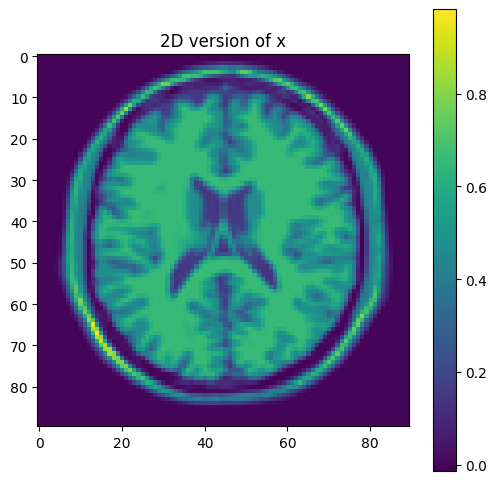

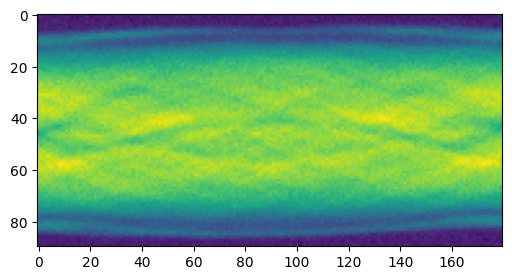

In [7]:
# Here, N = 90 ×  90 pixels and M = 90 ×180 measurements. Display a 2D version of x and a 2D version of y

N = (90, 90)
M = (90, 180)

x_2d = x.reshape(N, order='F')
y_2d = y.reshape(M, order='F')

plt.figure(figsize=(6, 6))
plt.imshow(x_2d)
plt.title('2D version of x')
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(y_2d)
plt.show()

Gradient de $f$ :

$ \nabla f(x) = H^\top (Hx - y) + \lambda  \nabla r(x)$


Avec, 
$\nabla r(x) = \left( \sum_{n=1}^{2N} G_{n,j} \psi'\left([Gx]_n\right) \right)_{j \in \{1, \dots, N\}} = \frac{1}{\delta^2} G^T z$

où $ z = (\frac{[Gx]^{(n)}}{\Psi([Gx]^{(n)})})_{n = 1, ... 2N}$


Conclusion,
$ \nabla f(x) = H^\top (Hx - y) + \lambda  \frac{1}{\delta^2} G^T z$

In [ ]:
lambd, delta = 0.13, 0.02

psi = lambda u: np.sqrt(1 + (u/delta)**2)

def psi_prime(u):
    return u/(delta**2*psi(u))

def gradient_r_old(x):
    N = x.shape[0]
    Gx = G_sparse@x
    psi_prime = Gx/(delta**2*psi(Gx))
    r_grad = np.zeros((N,1))
    for n in range(0, 2*N):
        r_grad += np.sum(G_sparse[n, :]*psi_prime[n])
    return r_grad

def gradient_f(x):
    Gx = G_sparse@x
    psi_prime = 1/delta**2 * Gx/psi(Gx)
    gradient = np.dot(H_sparse.T, H_sparse @ x - y) + lambd * G_sparse.T @ psi_prime
    return gradient

print("Gradient of f(x):", gradient_f(x).shape)

def f(x):
    r = np.sum(psi(G_sparse @ x))
    return 1/2*np.linalg.norm(H_sparse @ x - y)**2 + lambd*r

Soient $x_1$ and $x_2$.

$||\nabla f(x_1) - \nabla f(x_2)|| \leq ||H||^2 |x_1 - x_2| + \frac{\lambda}{\delta^2} |\frac{[Gx_1]^n}{\Psi([Gx_1]^n)} - \frac{[Gx_2]^n}{\Psi([Gx_2]^n)}|$

$||\nabla f(x_1) - \nabla f(x_2)|| \leq ||H||^2 |x_1 - x_2| + \frac{\lambda}{\delta^2} G^TG|x_1 - x_2|$

$||\nabla f(x_1) - \nabla f(x_2)|| \leq (||H||^2 + \frac{\lambda}{\delta^2} ||G||^2) |x_1 - x_2|$

In [6]:
H_norm = svds(H, k=1)[1][0]
G_norm = svds(G, k=1)[1][0]

L = H_norm**2 + (lambd / delta**2) * G_norm**2
L

np.float64(18092.773276864813)

In [7]:
x0 = np.zeros((H.shape[1], 1))
print(x0.shape)

(8100, 1)


In [8]:
def gradient_f_efficace(x, HTH, HTy):
    Gx = G_sparse @ x
    psi_prime = 1/delta**2 * Gx/psi(Gx)
    gradient = HTH @ x - HTy + lambd * G_sparse.T @ psi_prime
    return gradient

def gradient_descent(x0, y, lr=1e-4, max_iter=5000, threshold = 1e-4):
    x = x0
    HTH = H_sparse.T @ H_sparse
    HTy = H_sparse.T @ y 

    for iter in tqdm.tqdm(range(max_iter)):
        gradient = gradient_f_efficace(x, HTH, HTy)
        x -= lr * gradient
        if np.linalg.norm(gradient) <= threshold:
            break
    return x

x_opt = gradient_descent(x0, y)

 11%|█▏        | 563/5000 [01:07<08:51,  8.35it/s]  


: 

: 

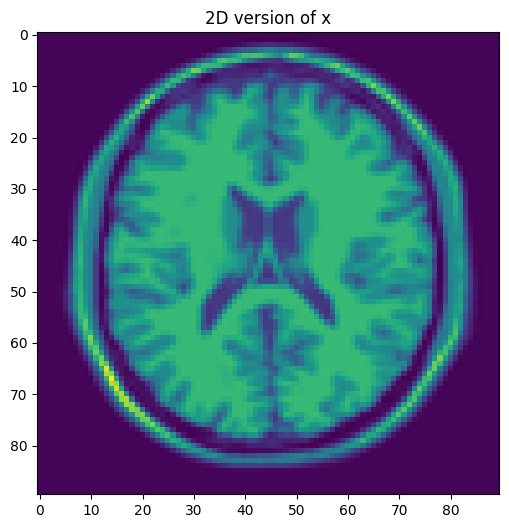

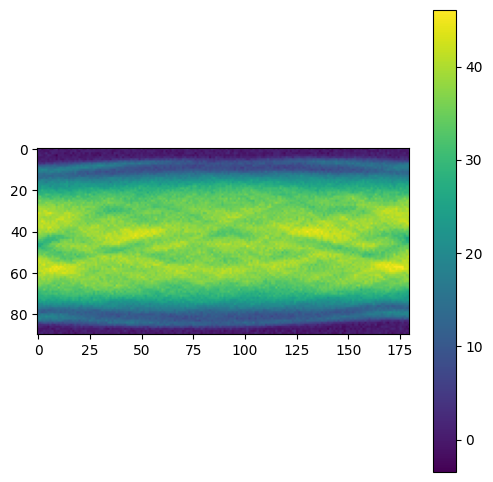

In [39]:
# Visualiser les résultats 
y = H @ x_opt + np.random.normal(0, 1, H.shape[0]).reshape(-1, 1)

x_opt_2d = x.reshape(N, order='F')
y_opt_2d = y.reshape(M, order='F')

plt.figure(figsize=(6, 6))
plt.imshow(x_opt_2d)
plt.title('2D version of x')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(y_opt_2d)
plt.colorbar()
plt.show()

$A(x) = H^TH + \lambda G^T \Omega(x)G$

Where
$\Omega(x) = \text{Diag}[(w([Gx]^{(n)}))_n]$

and 
$w(u) = \frac{\Psi'(u)}{u}$

In [54]:
# 3.2 MM quadratic algorithm
from scipy.sparse import csr_matrix
G_sparse = csr_matrix(G)

HTH = H.T@H


def omega(u):
    return 1/(delta**2 * np.sqrt(1 + (u/delta)**2))

def Omega(x):
    return diags(omega(G @ x).reshape(-1)).tocsc()

def curvature_matrix(x):
    Omega_x = Omega(x)
    GG_Omega = G_sparse.T @ Omega_x @ G_sparse   
    return HTH + lambd * GG_Omega

def A_op(x):
    matvec_op = lambda u : curvature_matrix(x) @ u
    A = LinearOperator(shape=(H.shape[1], H.shape[1]), matvec=matvec_op, rmatvec=matvec_op)
    return A

def gradient_f_efficace(x, HTH, HTy):
    Gx = G_sparse @ x
    psi_prime = 1/delta**2 * Gx/psi(Gx)
    gradient = HTH @ x - HTy + lambd * G_sparse.T @ psi_prime
    return gradient

def MM_algo(x0, max_iter=5000, threshold=1e-4):
    x = x0
    f_values_mm = []
    HTH = H.T @ H
    HTy = H.T @ y 
    for iter in tqdm.tqdm(range(max_iter)):
        grad = gradient_f_efficace(x, HTH, HTy)
        x += bicg(A_op(x), -grad)[0]
        print('ok')

        f_values_mm.append(f(x))
 
        if np.linalg.norm(grad) <= threshold:
            break
    return x, f_values_mm

: 

In [55]:
x_mm, f_values_mm = MM_algo(x0, max_iter=2)

  0%|          | 0/2 [24:27<?, ?it/s]


ValueError: non-broadcastable output operand with shape (8100,1) doesn't match the broadcast shape (8100,8100)

to do : checker si f bien décroissante puis retirer calcul dans la fonction

In [ ]:
plt.figure()
plt.plot(f_values_mm)
plt.show()